To give you some context, in the project I used this code for we had the following notation:
$$
y = |Ax| \text{ with } x = W^{(L)}W^{(L-1)}\cdots W^{(2)}W^{(1)}z
$$
with the aspect ratio of $A$ being $\alpha$ and the aspect ratio of $W^{(l)}$ being $\beta_{l}$. Note that this means that if $W^{(l)}\in\mathbb{R}^{k_{l+1}\times k_{l}}$, then $\beta_{l} = k_{l+1}/k_{l}$ for $1\leq l \leq L$. Therefore, if we define the convention $\beta_{L+1} = \alpha$ we can write everything in terms of a vector $\vec{\beta}\in\mathbb{R}^{L+1}$ with elements given by the aspect ratio of every layer.

In this notation, we can write the state evolution as follows:
\begin{align}
\begin{cases}
\hat{q}^{t}_{x} =\beta_{L+1}\Lambda_{y}\left(q_{x}^{t}\right)	\\
\hat{q}^{t}_{L} =\beta_{L}\Lambda_{out}\left(\hat{q}^{t}_{x}, q^{t}_{L}\right)	\\
\hat{q}^{t}_{L-1} =\beta_{L-1}\Lambda_{out}\left(\hat{q}^{t}_{L}, q^{t}_{L-1}\right)\\
\hspace{1cm}\vdots\\
\hat{q}^{t}_{l} =\beta_{l} \Lambda_{out}\left(\hat{q}^{t}_{l+1}, q^{t}_{l}\right)\\
\hspace{1cm}\vdots\\
\hat{q}^{t}_{z} =\beta_{1} \Lambda_{out}\left(\hat{q}^{t}_{2},q^{t}_{z}\right)
\end{cases}&&
\begin{cases}
	q^{t+1}_{x} = \Lambda_{x}\left(\hat{q}^{t}_{x}, q^{t}_{L}\right)\\
    q^{t+1}_{L} = \Lambda_{x}\left(\hat{q}^{t}_{L}, q^{t}_{L-1}\right)\\
\hspace{1cm}\vdots\\
{q}^{t+1}_{l} = \Lambda_{x}\left(\hat{q}^{t}_{l},q^{t}_{l-1}\right) \\
\hspace{1cm}\vdots\\
q^{t+1}_{z} =\Lambda_{z}\left(\hat{q}^{t}_{z}\right)
\end{cases}
\end{align}
where the update functions are given by:
\begin{align}
\Lambda_{x}(x,y) = 1-\frac{1-y}{1+x(1-y)} && \Lambda_{out}(x,y) = \frac{x}{1+x(1-y)} && \Lambda_{z}(x) = \frac{x}{1+x}
\end{align}
and (this is all you would change if you want to do complex channel):
\begin{align}
\Lambda_{y}(x) = \frac{1}{(1-x)^2}\mathbb{E}_{\xi,\eta}\left[(\sqrt{1-x}\xi + \sqrt{x}\eta)^2\tanh^2\left(\sqrt{\frac{x}{1-x}}\xi\eta+\frac{x}{1-x}\xi^2\right)\right]
\end{align}
for $\xi,\eta\sim\mathcal{N}(0,1)$.

Note that these equations are for the matrices with variance $1$, such that all the hidden variables $h^{l} = W^{l}h^{l-1}$ have zero mean and variance $1$. If this is not the case, we will also need a vector of second moments $\vec{\rho}\in\mathbb{R}^{L+1}$ and slightly adapt the updates above in the usual way.

In your notation, you want to write everything with respect to the dimension of $z$ instead. If we call your parameters $\gamma_{l} = k_{l}/k_{1}$, then we simply have:
$$
\prod_{k=l}^{1}\beta_{l} = k_{l+1}/k_{1} = \gamma_{l+1}
$$
So I would write a function that takes your parameters $\gamma_{l}$ and produce the vector of aspect ratios $\beta_{l}$, and then use the code below as it is.

Libraries I will use:

In [1]:
import numpy as np
import math
from scipy.special import erf
from scipy.integrate import nquad
import matplotlib.pyplot as plt

Here I just define the functions $\Lambda_{y}, \Lambda_{x}, \Lambda_{out}, \Lambda_{z}$ I need in the SE equations:

In [2]:
def gaussian(x):
    return np.exp(-1/2 * x**2)/np.sqrt(2*np.pi)

def Lx(x, y):
    return 1 - (1-y)/(1+x*(1-y))

def Lout(x, y):
    return x/(1+x*(1-y))

def Lpr(x, int_lims=10):
    opts = {'epsabs': 1.49e-08, 'epsrel': 1.49e-08, 'limit': 100} # parameters for numerical integration
    
    def Qpr(y,xi):
        omega = np.sqrt(x)*xi
        V = 1-x
        
        return gaussian(xi)*gaussian(y)*(np.sqrt(V)*y + omega)**2 * np.tanh(omega*y/np.sqrt(V)+omega**2/V)**2 
    
    return 1/(1-x)**2 * (nquad(Qpr, [[-int_lims, int_lims],[-int_lims, int_lims]], opts=opts)[0] - x)

def Lz(x):
    return x/(1+x)

Note that the saddle point equations can be written vectorially in terms of an overlap vector $\vec{q}\in\mathbb{R}^{L+1}$ with $q_{L+1} \equiv q_{x}$ and $q_{1}\equiv q_{z}$. Therefore here I write the updates $\vec{q}^{t}\to\vec{q}^{t+1}$ in terms of the two $L+1$ dimensional arrays $\vec{q}, \vec{\beta}\in\mathbb{R}^{L+1}$. 

Note as well that I don't keep track of the hat variables since I don't care about them.

The only important thing to notice here is that the updates are done top down: from $q^{t}_{L+1}\equiv q^{t}_{x}$ you can get $\hat{q}^{t}_{x}$ which allows you to get $q^{t+1}_{L+1}$ (together with $q_{L}^{t}$) and so on...

In [3]:
def update_se(qs, betas):
    LAYERS = len(betas) - 1 # Since python counts from 0
    qsnew = np.zeros(LAYERS+1)
    qhat = 0
    for l in range(LAYERS, -1, -1):
        if l == LAYERS: 
            # Phase retrieval layer
            qhat = betas[l] * Lpr(qs[l])
            qsnew[l] = Lx(qhat, qs[l-1])
            
        elif l != 0: 
            # Intermediate layer
            qhat = betas[l]*Lout(qhat, qs[l])
            qsnew[l] = Lx(qhat, qs[l-1])
            
        else: 
            # First layers
            qhat = betas[l] * Lout(qhat, qs[l])
            qsnew[l] = Lz(qhat)
            
    return qsnew

This is the routine that iterates the updates for you. Business as usual. I didn't use damping here, but the function is there if you want to include.

In [7]:
def damping(q_new, q_old, coef_damping=0.3):
    return (1 - coef_damping) * q_new + coef_damping * q_old

def iterate_se(betas, max_iter=1000, eps=1e-7, init_condition=0.001, last=False):
    """ 
    Update state evolution equations. 
    
    Parameters:
    * eps = threshold to reach convergence.
    * max_iter = maximum number of steps if convergence not reached.
    """
    LAYERS = len(betas) - 1
    
    # Initialise qu and qv
    qs = np.zeros((max_iter, LAYERS+1))
    
    qs[0] = init_condition
        
    for t in range(max_iter - 1):
        qs[t + 1] = update_se(qs[t], betas)
                
        diff = np.linalg.norm(qs[t + 1] - qs[t])
        
        # If you want to keep track of the values at each iteration:
        #print('t: {}, qs: {}'.format(t, qs[t+1]))
        
        # Precision for convergence
        if diff < eps: 
            break
    
    if last:
        return qs[t + 1]
    else:
        return qs[:t + 1]

Quick check everything is running well.

In [8]:
betas = [1, 1, 0.5]
qs = iterate_se(betas, init_condition=0.999)
mses = 1-qs

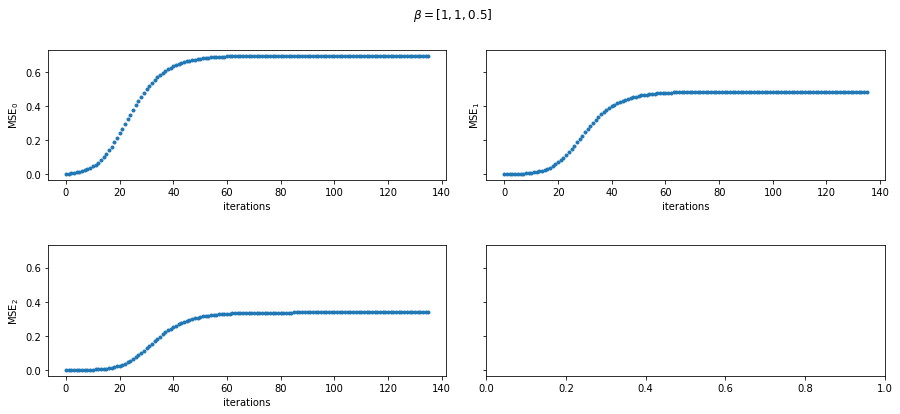

In [12]:
n_plots = len(mses[0])
n_rows = math.ceil(len(mses[0])/2)
                   
fig, axs = plt.subplots(n_rows, 2, figsize=(15, 6), sharey=True)
fig.subplots_adjust(hspace = .5, wspace=.1)
fig.suptitle(r"$\beta={}$".format(betas))
axs = axs.ravel()


for k, mse in enumerate(mses.T):
    axs[k].plot(mse, ".")
    axs[k].set_xlabel("iterations")
    axs[k].set_ylabel(r"MSE$_{}$".format(k))

### Phase diagram with square matrices

Here I fix all $\beta_{l}$ to be one and vary $\alpha$ (which, remember, is the last layer aspect ratio). This will give the the MSE as a function of $\alpha$ in the case where all matrices are square.

In [14]:
alphas = np.linspace(0.1, 1.5, 10)
overlaps = np.zeros((len(alphas),3))
for k, alpha in enumerate(alphas):
    #print('alpha: {}'.format(alpha))
    betas = [1,1, alpha]
    overlaps[k] = iterate_se(betas, init_condition=0.001, last=True) 

t: 0, qs: [0.00019909 0.00119874 0.00119877]
t: 1, qs: [0.00023846 0.00043751 0.00143673]
t: 2, qs: [0.00028549 0.00052389 0.00072291]
t: 3, qs: [0.00014411 0.00042953 0.00066789]
t: 4, qs: [0.00013317 0.00027726 0.00056263]
t: 5, qs: [0.00011224 0.00024539 0.00038946]
t: 6, qs: [7.77526826e-05 1.89977683e-04 3.23116937e-04]
t: 7, qs: [6.45278058e-05 1.42274618e-04 2.54489299e-04]
t: 8, qs: [5.08385065e-05 1.15362336e-04 1.93103827e-04]
t: 9, qs: [3.85865603e-05 8.94226324e-05 1.53942971e-04]
t: 10, qs: [3.07668428e-05 6.93519753e-05 1.20185866e-04]
t: 11, qs: [2.40239084e-05 5.47898501e-05 9.33737058e-05]
t: 12, qs: [1.86667314e-05 4.26900914e-05 7.34552329e-05]
t: 13, qs: [1.46860881e-05 3.33524870e-05 5.73753570e-05]
t: 14, qs: [1.14720455e-05 2.61579283e-05 4.48240304e-05]
t: 15, qs: [8.96295889e-06 2.04348791e-05 3.51205789e-05]
t: 16, qs: [7.02298161e-06 1.59858639e-05 2.74576723e-05]
t: 17, qs: [5.49084114e-06 1.25137758e-05 2.14765898e-05]
t: 18, qs: [4.29489376e-06 9.78570618e

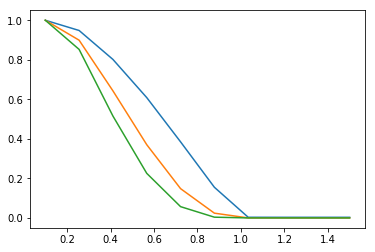

In [21]:
q1 = [1-overlaps[k][0] for k in range(10)]
q2 = [1-overlaps[k][1] for k in range(10)]
q3 = [1-overlaps[k][2] for k in range(10)]

plt.plot(alphas, q1)
plt.plot(alphas, q2)
plt.plot(alphas, q3)